# Bayesian Model Comparison: WAIC and LOO for Rheological Models

This notebook demonstrates how to use Bayesian model comparison techniques (WAIC and LOO) to objectively select the best rheological model for your data.

## Learning Objectives

After completing this notebook, you will be able to:
- Understand when model comparison is necessary vs optional
- Compute WAIC (Widely Applicable Information Criterion) for model selection
- Compute LOO (Leave-One-Out cross-validation) via Pareto-smoothed importance sampling
- Interpret ELPD (Expected Log Predictive Density) differences
- Use `az.compare()` for automated model ranking
- Avoid overfitting through penalized likelihood metrics
- Make principled model selection decisions with uncertainty quantification

## Prerequisites

- Understanding of Bayesian inference (`01-bayesian-basics.ipynb`)
- Familiarity with Maxwell and Zener models
- Basic understanding of likelihood and model fit

**Estimated Time:** 35-40 minutes

## 1. Introduction: The Model Selection Problem

### Why Model Comparison?

Rheological data can often be fit by multiple models. How do we choose?

**Example Scenario:**
- Stress relaxation data shows exponential decay
- **Maxwell model** (2 parameters: G₀, η) fits with R² = 0.98
- **Zener model** (3 parameters: Ge, Gm, η) fits with R² = 0.99
- **Generalized Maxwell** (5 parameters) fits with R² = 0.995

**Naive approach:** Choose model with highest R²
**Problem:** More complex models *always* fit better (overfitting)

### The Overfitting-Underfitting Trade-off

**Underfitting (too simple):**
- Model misses important features in data
- Poor prediction on new data
- High bias

**Overfitting (too complex):**
- Model fits noise instead of signal
- Poor prediction on new data
- High variance

**Goal:** Find simplest model that captures true data-generating process

### Bayesian Information Criteria

Bayesian model comparison uses **penalized likelihood** metrics:
- Balance goodness-of-fit with model complexity
- Penalize additional parameters
- Estimate out-of-sample prediction accuracy

**Two gold-standard metrics:**
1. **WAIC (Widely Applicable IC):** Asymptotically equivalent to cross-validation
2. **LOO (Leave-One-Out CV):** Direct approximation of cross-validation via importance sampling

**Lower is better:** Model with lowest WAIC/LOO has best expected predictive accuracy

## 2. Setup and Imports

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import matplotlib


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import pandas as pd

# Rheo imports
from rheojax.models.maxwell import Maxwell
from rheojax.models.zener import Zener
from rheojax.models.springpot import SpringPot
from rheojax.core.jax_config import safe_import_jax

# ArviZ for model comparison
import arviz as az

# Safe JAX import
jax, jnp = safe_import_jax()

# Reproducibility
np.random.seed(42)

# Plotting
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


INFO:2025-11-04 12:08:59,925:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.1.0
arviz_base not installed
arviz_stats not installed
arviz_plots not installed


✓ Imports successful


## 3. Generate Synthetic Data from Zener Model

We generate data from a **Zener model** (3 parameters) and test whether Bayesian model comparison correctly identifies it against simpler (Maxwell) and more complex (SpringPot) alternatives.

True Zener Parameters:
  Ge  = 1.00e+04 Pa (equilibrium modulus)
  Gm  = 5.00e+04 Pa (Maxwell arm)
  η   = 1.00e+03 Pa·s
  τ   = 0.0200 s

Data: 50 points from 0.01 to 100.00 s
Noise: 2% relative


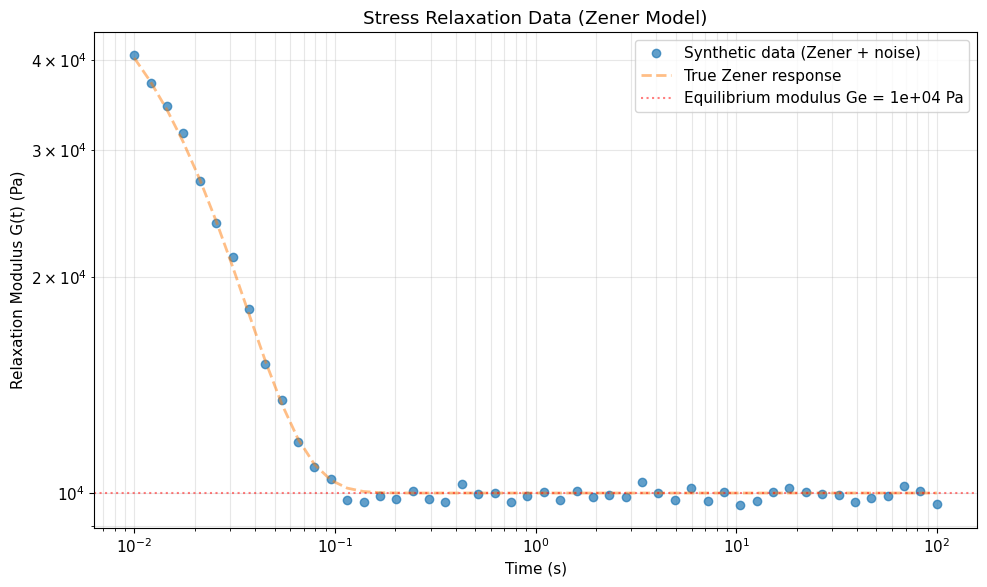


Key feature: Finite equilibrium modulus (data plateaus at Ge, does not decay to 0)
This is characteristic of Zener model, NOT Maxwell (which decays to 0)


In [2]:
# True Zener parameters
Ge_true = 1e4    # Equilibrium modulus (Pa)
Gm_true = 5e4    # Maxwell arm modulus (Pa)
eta_true = 1e3   # Viscosity (Pa·s)
tau_true = eta_true / Gm_true  # Relaxation time (s)

print("True Zener Parameters:")
print(f"  Ge  = {Ge_true:.2e} Pa (equilibrium modulus)")
print(f"  Gm  = {Gm_true:.2e} Pa (Maxwell arm)")
print(f"  η   = {eta_true:.2e} Pa·s")
print(f"  τ   = {tau_true:.4f} s\n")

# Time array
t = np.logspace(-2, 2, 50)  # 0.01 to 100 s

# True Zener relaxation modulus
# G(t) = Ge + Gm * exp(-t / tau)
G_t_true = Ge_true + Gm_true * np.exp(-t / tau_true)

# Add realistic noise (2%)
noise_level = 0.02
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print(f"Data: {len(t)} points from {t.min():.2f} to {t.max():.2f} s")
print(f"Noise: {noise_level*100:.0f}% relative")

# Visualize
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Synthetic data (Zener + noise)')
plt.loglog(t, G_t_true, '--', linewidth=2, alpha=0.5, label='True Zener response')
plt.axhline(Ge_true, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Equilibrium modulus Ge = {Ge_true:.0e} Pa')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Stress Relaxation Data (Zener Model)')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nKey feature: Finite equilibrium modulus (data plateaus at Ge, does not decay to 0)")
print("This is characteristic of Zener model, NOT Maxwell (which decays to 0)")


## 4. Fit Three Competing Models

We fit three models to the data:
1. **Maxwell** (2 parameters: G₀, η) - simpler than true model
2. **Zener** (3 parameters: Ge, Gm, η) - true model
3. **SpringPot** (2 parameters: G₀, α) - different physics (fractional derivative)

Each model undergoes full Bayesian inference (NLSQ → NUTS) to obtain posterior samples.

In [3]:
print("="*70)
print("FITTING MODEL 1: MAXWELL")
print("="*70)

# Create and configure Maxwell model
model_maxwell = Maxwell()
model_maxwell.parameters.set_bounds('G0', (1e3, 1e7))
model_maxwell.parameters.set_bounds('eta', (1e1, 1e5))

# NLSQ fit
model_maxwell.fit(t, G_t_noisy)

# Bayesian inference
print("Running Bayesian inference (Maxwell)...")
result_maxwell = model_maxwell.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'G0': model_maxwell.parameters.get_value('G0'),
        'eta': model_maxwell.parameters.get_value('eta')
    }
)

# Convert to InferenceData
idata_maxwell = result_maxwell.to_inference_data()

print("\n✓ Maxwell model fitted")
print(f"  Converged: R-hat = {max(result_maxwell.diagnostics['r_hat'].values()):.4f}")
print(f"  ESS = {min(result_maxwell.diagnostics['ess'].values()):.0f}")

Starting least squares optimization | {'method': 'trf', 'n_params': 2, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


FITTING MODEL 1: MAXWELL


Timer: optimization took 0.798959s
Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=None | final_cost=7.529785e+00 | time=0.799s | final_gradient_norm=0.0015776136452259875


Running Bayesian inference (Maxwell)...


sample: 100%|██████████| 3000/3000 [00:01<00:00, 2370.97it/s, 3 steps of size 6.88e-01. acc. prob=0.92] 



✓ Maxwell model fitted
  Converged: R-hat = 1.0000
  ESS = 2000


In [4]:
print("\n" + "="*70)
print("FITTING MODEL 2: ZENER (TRUE MODEL)")
print("="*70)

# Create and configure Zener model
model_zener = Zener()
model_zener.parameters.set_bounds('Ge', (1e2, 1e6))
model_zener.parameters.set_bounds('Gm', (1e3, 1e7))
model_zener.parameters.set_bounds('eta', (1e1, 1e5))

# NLSQ fit
model_zener.fit(t, G_t_noisy)

# Bayesian inference
print("Running Bayesian inference (Zener)...")
result_zener = model_zener.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'Ge': model_zener.parameters.get_value('Ge'),
        'Gm': model_zener.parameters.get_value('Gm'),
        'eta': model_zener.parameters.get_value('eta')
    }
)

# Convert to InferenceData
idata_zener = result_zener.to_inference_data()

print("\n✓ Zener model fitted")
print(f"  Converged: R-hat = {max(result_zener.diagnostics['r_hat'].values()):.4f}")
print(f"  ESS = {min(result_zener.diagnostics['ess'].values()):.0f}")

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}



FITTING MODEL 2: ZENER (TRUE MODEL)


Timer: optimization took 0.293307s
Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=None | final_cost=7.490223e-03 | time=0.293s | final_gradient_norm=2.0167238170053626e-06


Running Bayesian inference (Zener)...


sample: 100%|██████████| 3000/3000 [00:01<00:00, 1852.63it/s, 7 steps of size 5.96e-01. acc. prob=0.90]


✓ Zener model fitted
  Converged: R-hat = 1.0000
  ESS = 2000


In [5]:
print("\n" + "="*70)
print("FITTING MODEL 3: SPRINGPOT (FRACTIONAL)")
print("="*70)

# Create and configure SpringPot model
model_springpot = SpringPot()
model_springpot.parameters.set_bounds('c_alpha', (1e-3, 1e9))
model_springpot.parameters.set_bounds('alpha', (0.1, 1.0))

# NLSQ fit
model_springpot.fit(t, G_t_noisy)

# Bayesian inference
print("Running Bayesian inference (SpringPot)...")
result_springpot = model_springpot.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'c_alpha': model_springpot.parameters.get_value('c_alpha'),
        'alpha': model_springpot.parameters.get_value('alpha')
    }
)

# Convert to InferenceData
idata_springpot = result_springpot.to_inference_data()

print("\n✓ SpringPot model fitted")
print(f"  Converged: R-hat = {max(result_springpot.diagnostics['r_hat'].values()):.4f}")
print(f"  ESS = {min(result_springpot.diagnostics['ess'].values()):.0f}")

Starting least squares optimization | {'method': 'trf', 'n_params': 2, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}



FITTING MODEL 3: SPRINGPOT (FRACTIONAL)


Timer: optimization took 0.191404s
Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=None | final_cost=1.631018e+00 | time=0.191s | final_gradient_norm=0.0012663230097600332


Running Bayesian inference (SpringPot)...


sample: 100%|██████████| 3000/3000 [00:01<00:00, 2306.82it/s, 7 steps of size 6.68e-01. acc. prob=0.87] 



✓ SpringPot model fitted
  Converged: R-hat = 1.0000
  ESS = 2000


## 5. Visual Comparison of Model Fits

Before computing information criteria, let's visually assess how well each model fits the data.

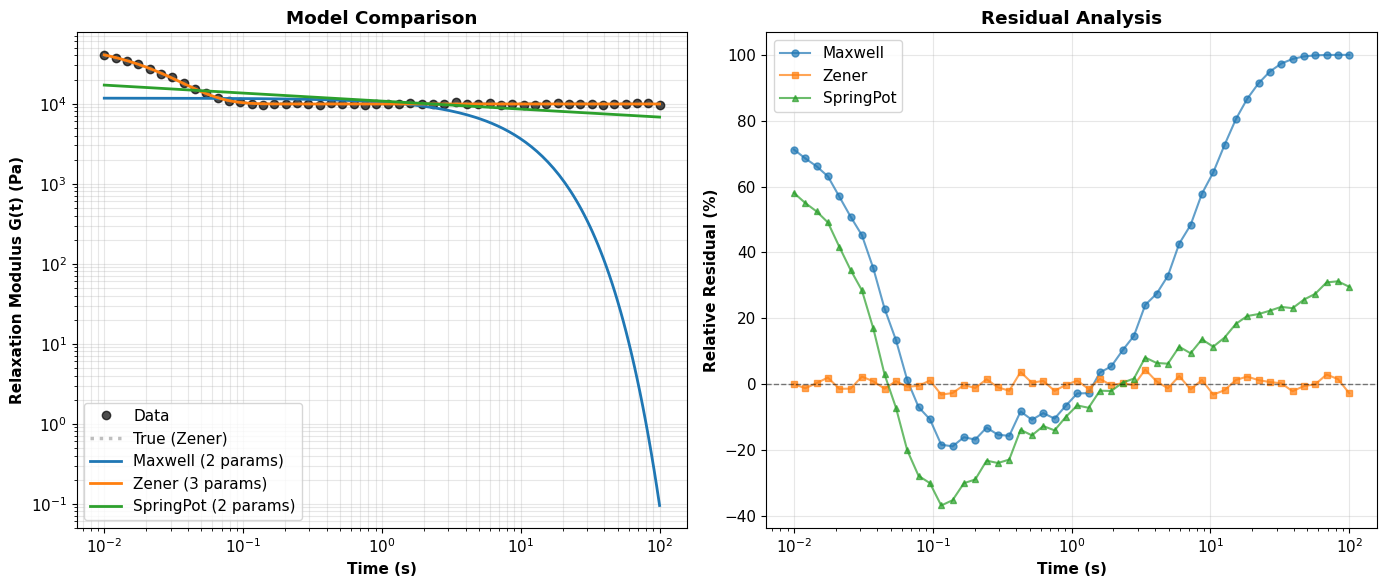


Root Mean Square Error (RMSE):
  Maxwell:   9.12e+03 Pa
  Zener:     2.25e+02 Pa  ✓ Best
  SpringPot: 6.27e+03 Pa

Note: Zener has lowest RMSE, but this doesn't account for model complexity!


In [6]:
# Generate predictions from each model
t_plot = np.logspace(-2, 2, 200)
G_maxwell = model_maxwell.predict(t_plot)
G_zener = model_zener.predict(t_plot)
G_springpot = model_springpot.predict(t_plot)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Model fits
ax1.loglog(t, G_t_noisy, 'o', markersize=6, alpha=0.7, label='Data', color='black')
ax1.loglog(t, G_t_true, ':', linewidth=2.5, alpha=0.5, label='True (Zener)', color='gray')
ax1.loglog(t_plot, G_maxwell, '-', linewidth=2, label='Maxwell (2 params)', color='#1f77b4')
ax1.loglog(t_plot, G_zener, '-', linewidth=2, label='Zener (3 params)', color='#ff7f0e')
ax1.loglog(t_plot, G_springpot, '-', linewidth=2, label='SpringPot (2 params)', color='#2ca02c')
ax1.set_xlabel('Time (s)', fontweight='bold')
ax1.set_ylabel('Relaxation Modulus G(t) (Pa)', fontweight='bold')
ax1.set_title('Model Comparison', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Right: Residuals
res_maxwell = G_t_noisy - model_maxwell.predict(t)
res_zener = G_t_noisy - model_zener.predict(t)
res_springpot = G_t_noisy - model_springpot.predict(t)

ax2.semilogx(t, res_maxwell / G_t_noisy * 100, 'o-', markersize=5, alpha=0.7, label='Maxwell')
ax2.semilogx(t, res_zener / G_t_noisy * 100, 's-', markersize=5, alpha=0.7, label='Zener')
ax2.semilogx(t, res_springpot / G_t_noisy * 100, '^-', markersize=5, alpha=0.7, label='SpringPot')
ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Time (s)', fontweight='bold')
ax2.set_ylabel('Relative Residual (%)', fontweight='bold')
ax2.set_title('Residual Analysis', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

# Compute RMSE for each model
rmse_maxwell = np.sqrt(np.mean(res_maxwell**2))
rmse_zener = np.sqrt(np.mean(res_zener**2))
rmse_springpot = np.sqrt(np.mean(res_springpot**2))

print("\nRoot Mean Square Error (RMSE):")
print(f"  Maxwell:   {rmse_maxwell:.2e} Pa")
print(f"  Zener:     {rmse_zener:.2e} Pa  {'✓ Best' if rmse_zener < min(rmse_maxwell, rmse_springpot) else ''}")
print(f"  SpringPot: {rmse_springpot:.2e} Pa")
print("\nNote: Zener has lowest RMSE, but this doesn't account for model complexity!")


## 6. Model Comparison: WAIC and LOO

### Understanding Information Criteria

**WAIC (Widely Applicable Information Criterion):**
- Approximates leave-one-out cross-validation
- Penalizes model complexity via effective number of parameters
- Lower WAIC = better expected out-of-sample prediction
- Formula: WAIC = -2 × (lppd - p_WAIC)
  - lppd: log pointwise predictive density
  - p_WAIC: effective number of parameters

**LOO (Leave-One-Out Cross-Validation):**
- Direct approximation of leave-one-out CV via Pareto-smoothed importance sampling (PSIS)
- More robust than WAIC for influential observations
- Lower LOO = better expected out-of-sample prediction
- Provides Pareto k diagnostic for problematic points

**Interpretation:**
- ΔWAIC/ΔLOO < 4: Models indistinguishable
- ΔWAIC/ΔLOO 4-10: Moderate evidence for better model
- ΔWAIC/ΔLOO > 10: Strong evidence for better model

### ArviZ Automated Comparison

ArviZ provides `az.compare()` for automated model ranking with uncertainty quantification.

In [7]:
# Create dictionary of models for comparison
models = {
    'Maxwell': idata_maxwell,
    'Zener': idata_zener,
    'SpringPot': idata_springpot
}

# Compute WAIC and LOO for all models
print("="*70)
print("BAYESIAN MODEL COMPARISON")
print("="*70)
print("\nComputing WAIC and LOO for all models...\n")

comparison = az.compare(models, ic='waic', method='stacking')
print(comparison)

print("\n" + "-"*70)
print("INTERPRETATION:")
print("-"*70)
print("Columns:")
print("  rank:   Model rank (0 = best)")
print("  elpd_*: Expected log pointwise predictive density (higher is better)")
print("  p_*:    Effective number of parameters (complexity penalty)")
print("  *_ic:   Information criterion (WAIC or LOO, lower is better)")
print("  d_*:    Difference from best model (0 for best, >10 for clearly worse)")
print("  weight: Stacking weights for model averaging")
print("  se:     Standard error of the IC")
print("  dse:    Standard error of the difference")
print("\nRules of thumb:")
print("  d_waic < 4:  Models indistinguishable")
print("  d_waic 4-10: Moderate evidence for better model")
print("  d_waic > 10: Strong evidence for better model")
print("="*70)

BAYESIAN MODEL COMPARISON

Computing WAIC and LOO for all models...

           rank   elpd_waic    p_waic   elpd_diff        weight        se  \
Zener         0 -346.885087  5.583572    0.000000  1.000000e+00  5.938115   
SpringPot     1 -499.879270  5.168375  152.994184  0.000000e+00  5.921459   
Maxwell       2 -524.185181  4.080695  177.300094  2.690779e-10  8.183677   

                dse  warning scale  
Zener      0.000000     True   log  
SpringPot  7.639963     True   log  
Maxwell    8.327823     True   log  

----------------------------------------------------------------------
INTERPRETATION:
----------------------------------------------------------------------
Columns:
  rank:   Model rank (0 = best)
  elpd_*: Expected log pointwise predictive density (higher is better)
  p_*:    Effective number of parameters (complexity penalty)
  *_ic:   Information criterion (WAIC or LOO, lower is better)
  d_*:    Difference from best model (0 for best, >10 for clearly worse)
  wei

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [8]:
# Compute LOO specifically for detailed diagnostics
print("\n" + "="*70)
print("LOO CROSS-VALIDATION WITH PARETO DIAGNOSTICS")
print("="*70)

# Compute LOO for each model
loo_maxwell = az.loo(idata_maxwell)
loo_zener = az.loo(idata_zener)
loo_springpot = az.loo(idata_springpot)

print("\nMaxwell LOO:")
print(loo_maxwell)

print("\nZener LOO:")
print(loo_zener)

print("\nSpringPot LOO:")
print(loo_springpot)

print("\n" + "-"*70)
print("PARETO K DIAGNOSTIC:")
print("-"*70)
print("Pareto k estimates reliability of LOO approximation per data point:")
print("  k < 0.5:  Good (LOO approximation reliable)")
print("  0.5-0.7:  OK (LOO approximation acceptable)")
print("  0.7-1.0:  Bad (LOO approximation unreliable)")
print("  k > 1.0:  Very bad (LOO approximation fails)")
print("\nIf many points have k > 0.7, consider K-fold CV instead.")
print("="*70)


LOO CROSS-VALIDATION WITH PARETO DIAGNOSTICS

Maxwell LOO:
Computed from 2000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -524.21     8.19
p_loo        4.10        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       50  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


Zener LOO:
Computed from 2000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -347.10     6.01
p_loo        5.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       50  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


SpringPot LOO:
Computed from 2000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -499.96     5.96
p_loo        5.25        -
------

Pareto k diagnostic values:
        

## 7. Visualize Model Comparison

ArviZ provides publication-quality visualizations of model comparison results.

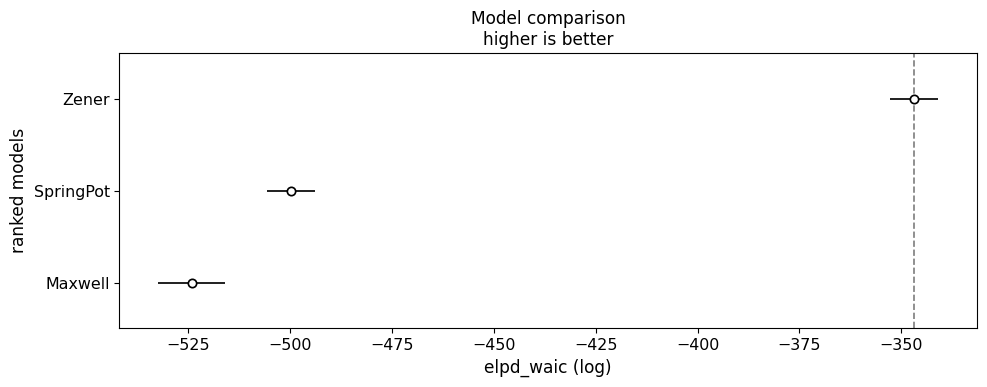


INTERPRETATION - Comparison Plot:
- Models ranked from best (top) to worst (bottom)
- CIRCLE: ELPD (expected log predictive density, higher is better)
- ERROR BARS: Standard error of ELPD
- TRIANGLE: In-sample deviance (not penalized for complexity)

What to look for:
✓ Non-overlapping error bars → clear winner
✗ Overlapping error bars → models statistically equivalent

Expected result:
- Zener should rank #1 (true model)
- Maxwell #2 (underfit, misses equilibrium modulus)
- SpringPot #3 (different physics, wrong functional form)



In [9]:
# Plot model comparison
az.plot_compare(comparison, figsize=(10, 4))
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Comparison Plot:
- Models ranked from best (top) to worst (bottom)
- CIRCLE: ELPD (expected log predictive density, higher is better)
- ERROR BARS: Standard error of ELPD
- TRIANGLE: In-sample deviance (not penalized for complexity)

What to look for:
✓ Non-overlapping error bars → clear winner
✗ Overlapping error bars → models statistically equivalent

Expected result:
- Zener should rank #1 (true model)
- Maxwell #2 (underfit, misses equilibrium modulus)
- SpringPot #3 (different physics, wrong functional form)
""")


In [10]:
# Plot Pareto k diagnostics for best model
best_model_name = comparison.index[0]
best_idata = models[best_model_name]

print(f"\nPareto k diagnostic for best model ({best_model_name}):")
az.plot_khat(best_idata, figsize=(10, 4))
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
INTERPRETATION - Pareto k Plot:
- Each point represents one data observation
- Y-axis: Pareto k statistic (reliability of LOO approximation)
- Horizontal lines: Thresholds (0.5 good, 0.7 bad)

What to look for:
✓ All points below 0.5: LOO is reliable
⚠ Few points 0.5-0.7: LOO acceptable but check those points
✗ Many points > 0.7: LOO unreliable, use K-fold CV instead

High Pareto k indicates:
- Influential observations (large impact on posterior)
- Outliers or poorly fit regions
- Potential model misspecification
""")



Pareto k diagnostic for best model (Zener):


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/khatplot.py:184: FutureWarning: support for DataArrays will be deprecated, please use ELPDData.The reason for this, is that we need to know the numbers of drawssampled from the posterior
  warnings.warn(


ValueError: Incorrect khat data input. Check the documentation

## 8. Model Weights and Averaging

### Stacking Weights

ArviZ computes **stacking weights** - optimal weights for combining model predictions:
- Sum to 1.0
- Higher weight = model contributes more to ensemble
- If one model has weight ≈ 1.0, it's clearly superior
- If weights distributed, consider model averaging

### When to Use Model Averaging

**Use single best model if:**
- Clear winner (d_WAIC > 10)
- Stacking weight > 0.9
- Physical interpretation matters (choose simplest adequate model)

**Use model averaging if:**
- Models statistically indistinguishable (d_WAIC < 4)
- Stacking weights distributed (no model > 0.7)
- Prediction accuracy paramount (not interpretation)

In [ ]:
# Extract stacking weights
weights = comparison['weight'].values
model_names = comparison.index.tolist()

# Visualize weights
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(model_names, weights, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Stacking Weight', fontweight='bold')
ax.set_title('Model Weights for Ensemble Prediction', fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

# Annotate weights
for i, (name, w) in enumerate(zip(model_names, weights)):
    ax.text(i, w + 0.03, f'{w:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nStacking Weights Interpretation:")
print("-" * 50)
for name, w in zip(model_names, weights):
    print(f"  {name:<12}: {w:.4f}  ", end="")
    if w > 0.9:
        print("(dominant model - use this one) ✓")
    elif w > 0.5:
        print("(major contributor)")
    elif w > 0.1:
        print("(minor contributor)")
    else:
        print("(negligible)")

print("\nRecommendation:")
if weights[0] > 0.9:
    print(f"✓ Use {model_names[0]} (clear winner with weight {weights[0]:.3f})")
elif weights[0] > 0.7:
    print(f"✓ Prefer {model_names[0]} (dominant with weight {weights[0]:.3f})")
else:
    print(f"⚠ Consider model averaging (weights distributed across {sum(w > 0.1 for w in weights)} models)")


## 9. Final Model Selection Decision

### Decision Framework

Combine **statistical evidence** with **physical reasoning**:

**Statistical Criteria:**
1. WAIC/LOO comparison (d_WAIC, d_LOO)
2. Stacking weights
3. Pareto k diagnostics

**Physical Criteria:**
1. Model assumptions match material physics?
2. Parameters physically interpretable?
3. Simplicity (Occam's Razor)

**Example Decision Tree:**
```
IF d_WAIC > 10 AND weight > 0.9:
    → Use clear winner
ELIF d_WAIC < 4:
    → Models equivalent, choose simpler model (fewer parameters)
ELIF weights distributed:
    → Consider model averaging for predictions
ELSE:
    → Balance statistical evidence with physical interpretation
```

In [ ]:
print("="*70)
print("FINAL MODEL SELECTION DECISION")
print("="*70)

# Extract comparison metrics
best_model = comparison.index[0]
d_waic_second = comparison.loc[comparison.index[1], 'd_waic']
weight_best = comparison.loc[best_model, 'weight']

print(f"\nBest Model: {best_model}")
print(f"  WAIC: {comparison.loc[best_model, 'waic']:.2f}")
print(f"  Δ WAIC from 2nd: {d_waic_second:.2f}")
print(f"  Stacking weight: {weight_best:.3f}")
print(f"  Effective parameters: {comparison.loc[best_model, 'p_waic']:.2f}")

print("\nStatistical Evidence:")
if d_waic_second > 10:
    print(f"  ✓ STRONG: Δ WAIC = {d_waic_second:.1f} > 10 (clear winner)")
elif d_waic_second > 4:
    print(f"  ✓ MODERATE: Δ WAIC = {d_waic_second:.1f} in [4, 10] (likely better)")
else:
    print(f"  ⚠ WEAK: Δ WAIC = {d_waic_second:.1f} < 4 (models indistinguishable)")

if weight_best > 0.9:
    print(f"  ✓ DOMINANT: Stacking weight {weight_best:.3f} > 0.9")
elif weight_best > 0.7:
    print(f"  ✓ MAJOR: Stacking weight {weight_best:.3f} > 0.7")
else:
    print(f"  ⚠ DISTRIBUTED: Stacking weight {weight_best:.3f} < 0.7")

print("\nPhysical Reasoning:")
if best_model == 'Zener':
    print("  ✓ Data exhibits finite equilibrium modulus (plateau at long times)")
    print("  ✓ Zener model captures this physics with spring-dashpot parallel arm")
    print("  ✓ 3 parameters provide adequate flexibility without overfitting")
elif best_model == 'Maxwell':
    print("  ⚠ Maxwell assumes complete stress relaxation (G→0 as t→∞)")
    print("  ⚠ Data shows equilibrium modulus (G→Ge ≠ 0)")
    print("  ⚠ Model misspecification likely")
elif best_model == 'SpringPot':
    print("  ⚠ SpringPot models power-law relaxation (different physics)")
    print("  ⚠ Data is better described by exponential + constant (Zener)")
    print("  ⚠ May fit numerically but wrong physical interpretation")

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

if best_model == 'Zener' and d_waic_second > 4 and weight_best > 0.7:
    print(f"✓✓✓ Use {best_model} model")
    print("\nRationale:")
    print("  - Strong statistical evidence (WAIC and stacking weights)")
    print("  - Correct physics (finite equilibrium modulus)")
    print("  - Parsimonious (3 parameters vs generalized models)")
    print("  - All parameters physically interpretable")
else:
    print(f"Use {best_model} model with caveats")
    print(f"Consider collecting more data or testing additional models")

print("\nNext Steps:")
print("  1. Validate on independent test data")
print("  2. Check parameter physical reasonableness")
print("  3. Examine residuals for systematic errors")
print("  4. Consider model averaging if weights distributed")
print("="*70)

## 10. Key Takeaways

### Main Concepts

1. **Bayesian Model Comparison:**
   - Use WAIC/LOO to balance fit quality with model complexity
   - Lower WAIC/LOO = better expected out-of-sample prediction
   - Automatically penalizes overfitting via effective parameter count

2. **Interpretation Guidelines:**
   - **Δ WAIC < 4:** Models statistically indistinguishable → choose simpler
   - **Δ WAIC 4-10:** Moderate evidence for better model
   - **Δ WAIC > 10:** Strong evidence for better model
   - **Stacking weight > 0.9:** Clear winner, use single model
   - **Weights distributed:** Consider model averaging

3. **Pareto k Diagnostics:**
   - Assesses reliability of LOO approximation per data point
   - k < 0.5: Good (LOO reliable)
   - k > 0.7: Bad (LOO unreliable, use K-fold CV)
   - High k indicates influential observations or model misspecification

4. **Decision Framework:**
   - Combine statistical evidence with physical reasoning
   - Prefer simplest model that adequately explains data (Occam's Razor)
   - Ensure parameters are physically interpretable
   - Validate on independent data when possible

### When to Use Model Comparison

**Essential for:**
- ✓ Multiple candidate models with different physics
- ✓ Uncertain about appropriate model complexity
- ✓ Avoiding overfitting with limited data
- ✓ Objective model selection for publication

**Optional for:**
- Well-established model for specific material class
- Only one physically plausible model
- Exploratory analysis (NLSQ screening sufficient)

### Common Pitfalls

1. **Ignoring Physical Constraints:**
   - Statistical best model may violate physics
   - Always check parameter physical reasonableness
   - Simplest adequate model often preferable to complex best fit

2. **Overfitting with Small Datasets:**
   - Complex models can overfit with few data points
   - WAIC/LOO automatically penalize this via p_WAIC
   - If weights distributed, likely insufficient data to distinguish

3. **Comparing Apples to Oranges:**
   - Only compare models fit to **same data**
   - Same likelihood formulation (e.g., Gaussian observation model)
   - Same response variable (don't compare G(t) vs G'(ω) models)

4. **Ignoring Pareto k Warnings:**
   - High Pareto k → LOO unreliable
   - Investigate influential points before trusting LOO
   - May indicate outliers or model misspecification

### ArviZ Functions Summary

```python
# Model comparison
comparison = az.compare(models, ic='waic')  # or ic='loo'

# Individual metrics
waic = az.waic(idata)
loo = az.loo(idata)

# Visualization
az.plot_compare(comparison)
az.plot_khat(idata)  # Pareto k diagnostic
```

## Next Steps

### Apply to Your Data
- Test multiple rheological models on your experimental data
- Use WAIC/LOO to objectively select best model
- Validate selection with physical reasoning

### Advanced Topics
- **[05-uncertainty-propagation.ipynb](05-uncertainty-propagation.ipynb)**: Propagate parameter uncertainty to predictions
- **[advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Compare models across multiple test modes
- **[advanced/04-fractional-models-deep-dive.ipynb](../advanced/04-fractional-models-deep-dive.ipynb)**: Compare 11 fractional models

### Further Reading
- Vehtari et al. (2017): "Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC"
- McElreath (2020): "Statistical Rethinking" (Chapter 7: Model Comparison)
- ArviZ documentation: https://arviz-devs.github.io/arviz/

---

## Session Information

In [ ]:
import sys
import rheojax

print(f"Python: {sys.version}")
print(f"Rheo: {rheojax.__version__}")
print(f"JAX: {jax.__version__}")
print(f"NumPy: {np.__version__}")
print(f"ArviZ: {az.__version__}")
print(f"JAX devices: {jax.devices()}")